In [2]:
import edenutil
import json
'''Imports'''

# essentials

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import collections
import ast

# read_data imports

import json
import operator
import itertools

# preprocess_data imports

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
import cPickle as pickle
from datetime import datetime
import time

# cluster_data imports

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import Birch
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics.pairwise import cosine_similarity

# visualization imports

from sklearn.manifold import TSNE

%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
fn = '1,12,2,20,21,23,28,29,30,33,35,40,5,6'
data = edenutil.read_data(fn)

[EDEN I/O -- read_data] Files: 
f:  1
f:  12
f:  2
f:  20
f:  21
f:  23
f:  28
f:  29
f:  30
f:  33
f:  35
f:  40
f:  5
f:  6
[EDEN I/O -- read_data] Data length:  2469
[EDEN I/O -- read_data] Data type:  <type 'list'>


1 95
12 346
2 89
20 97
21 412
23 85
28 301
29 183
30 35
33 45
35 23
40 287
5 430
6 41
****
1 24
12 21
2 12
20 9
21 49
23 15
28 4
29 5
30 17
33 8
35 6
40 9
5 149
6 10
[71, 325, 77, 88, 363, 70, 297, 178, 18, 37, 17, 278, 281, 31]


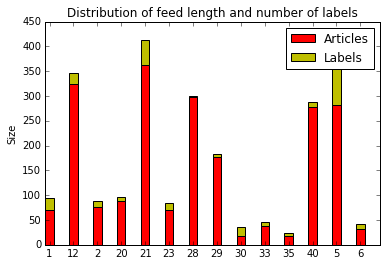

In [24]:
f_len = []
e_len = []

for f in fn.split(','):
    with open("../datasets/raw-data/" + str(f) + ".json", 'rb') as infile:
        data_l = json.load(infile)
        f_len.append(len(data_l))
        print f, len(data_l)
        
print "****"
    
for f in fn.split(','):
    df = pd.read_csv("../datasets/eval/" + str(f) +
                                 ".txt", sep='\t', names=['story', 'event', 'decision'])
#         print df['event'].unique()
    e_len.append(df.shape[0])
    print f, df.shape[0]
    
    
N = len(f_len)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

adj = [f_len[i] - e_len[i] for i in range(len(f_len))]

print adj
    
p1 = plt.bar(ind, adj, width, color='r')
p2 = plt.bar(ind, e_len, width, color='y',
             bottom=adj)

plt.ylabel('Size')
plt.title('Distribution of feed length and number of labels')
plt.xticks(ind + width/2., fn.split(','))
# plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Articles', 'Labels'))

plt.show()
    

In [26]:
print sum(e_len), sum(f_len)

338 2469


In [6]:
data_eval = edenutil.get_df_eval(fn)

1
12
2
20
21
23
28
29
30
33
35
40
5
6


In [7]:
data_eval.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338 entries, 0 to 9
Data columns (total 3 columns):
story       338 non-null object
event       338 non-null int64
decision    338 non-null object
dtypes: int64(1), object(2)
memory usage: 10.6+ KB


In [8]:
data_preprocess = edenutil.preprocess_data(json.loads(data), method='ltc')

[EDEN I/O -- preprocess_data] Preprocessing data
[EDEN I/O -- preprocess_data] VSM shape:  (2469, 35101)
[EDEN I/O -- preprocess_data] VSM type:  <class 'scipy.sparse.csr.csr_matrix'>


In [9]:
data_preprocess.head()

,index,content,content_prepro,entities,first-published,id,summary,title,first-published-epoch,vsm
0,2372,"Jul 17, 2015( Phil's Stock World: http://www.p...","jul 17 , 2015 ( phil ' stock world : http :// ...",Greek German Reuters Deal Donald Tusk Germany ...,2015-07-17T00:00:00Z,a7f0d852-41fb-4cdf-ac1c-622bdf170598,Frontrunning: July 17,Frontrunning: July 17,1437087600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1007,It’s time to upgrade your arm candy to somethi...,’ time upgrad arm candi someth littl bow...,,2015-07-27T10:51:10Z,c9fdda7e-8e3f-45df-a200-b5afb0fd58ee,Ted Presents Bowtiful,Ted Presents Bowtiful,1437990670,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1077,"Deliveroo, a London startup that allows restau...","deliveroo , london startup allow restaur offer...",London Accel Partners Index Ventures France Ge...,2015-07-28T00:01:00Z,0ad8883f-2d55-497b-8f5b-2d8e26e5b03a,Deliveroo gets fed £45m by Facebook investors,Deliveroo gets fed £45m by Facebook investors,1438038060,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,187,[ILLUSTRATION OMITTED] Eighteen S...,[ illustr omit ] eighteen sound ...,North America Italian,2015-08-01T00:00:00Z,54bd2c6e-b8d6-47d9-9f1b-5e53619b89b1,Eighteen Sound,Eighteen Sound,1438383600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,Media Type:PrintSource:Chat (GB)Date Published...,media type : printsourc : chat ( gb ) date pub...,Tesco PLC Tesco,2015-08-06T00:00:00Z,d8faa5c5-4ee3-494d-940d-f16ef374c8a8,Tesco Clubcard,Tesco Clubcard,1438815600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [73]:
vsm = edenutil.recon_vsm(data_preprocess['vsm'])

In [75]:
def reduce_and_plot_data(X, X_eval, event_idx, title="", with_noise=True):
    X_reduced = TruncatedSVD().fit_transform(X)
    X_embedded = TSNE(learning_rate=100).fit_transform(X_reduced)

#     n_clus = len(set(model.labels_.tolist()))

    plt.figure(figsize=(10, 10))
    plt.title(title)
    if with_noise:
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x", c='k')
#     , c=model.labels_.tolist(), cmap=plt.cm.get_cmap("prism", n_clus)
#     plt.colorbar(ticks=range(n_clus))
#     plt.clim(-0.5, (n_clus - 0.5))
    
    # now color labelled points
    events = data_eval['event'].unique()

    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, len(events)))
#     colors = plt.cm.get_cmap("prism", len(events))
    
    for event, color in zip(events, colors):
        event_vsm = X_embedded[event_idx[event]]
        plt.scatter(event_vsm[:, 0], event_vsm[:, 1], label=str(event), marker="x", c=color)


    plt.legend()
    plt.savefig('i/reduce_and_plot_clusters' +
                str(datetime.now()) + '.png')
    plt.show()

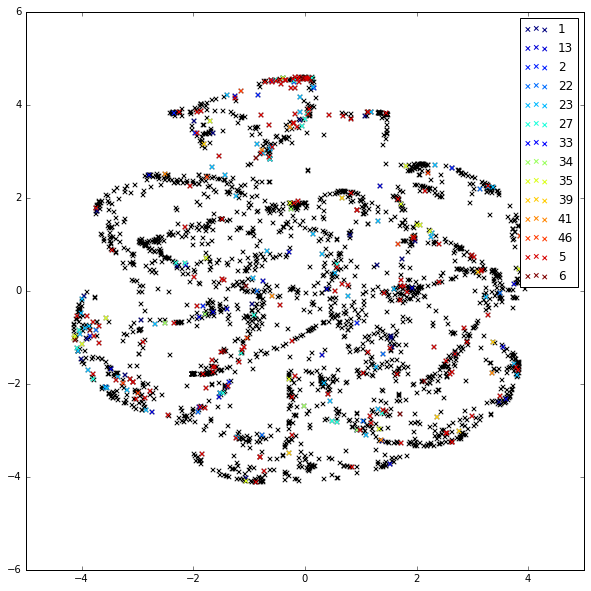

In [58]:
reduce_and_plot_data(vsm, data_eval, event_idx)

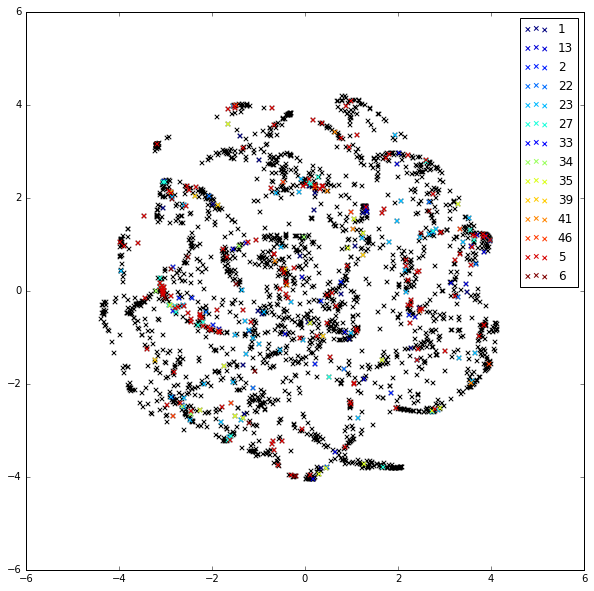

In [74]:
reduce_and_plot_data(vsm, data_eval, event_idx)

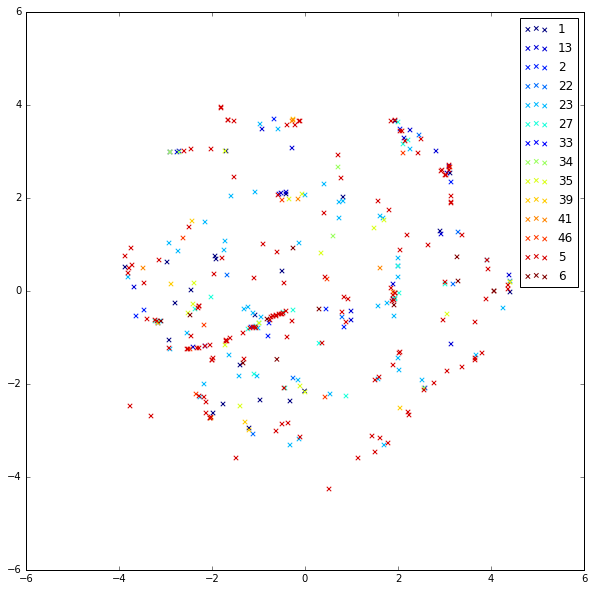

In [76]:
reduce_and_plot_data(vsm, data_eval, event_idx, with_noise=False)

In [36]:
data_merge = pd.merge(data_preprocess, data_eval, left_on='id', right_on='story', how='right')

In [41]:
event_idx = {}
for name, group in data_merge.groupby('event'):
#     print name, group.index.values/
    event_idx[name] = group.index.values

In [42]:
event_idx

{1: array([173, 174, 175, 176, 177, 188, 189, 190, 193, 194, 195, 197, 268,
        270, 274, 275, 276, 279, 285, 292, 293, 319, 320, 323]),
 2: array([180, 181, 182, 183, 184, 185, 186, 203, 338, 339, 340, 341]),
 5: array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  51,  52,  53,  54,
         55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
        107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
        133, 134, 135, 136, 137, 138, 139, 140, 141, 

In [77]:
fig = plt.figure()
plt.plot(data_preprocess['first-published'].resample(’H’))

SyntaxError: invalid syntax (<ipython-input-77-dd63004bbc51>, line 2)

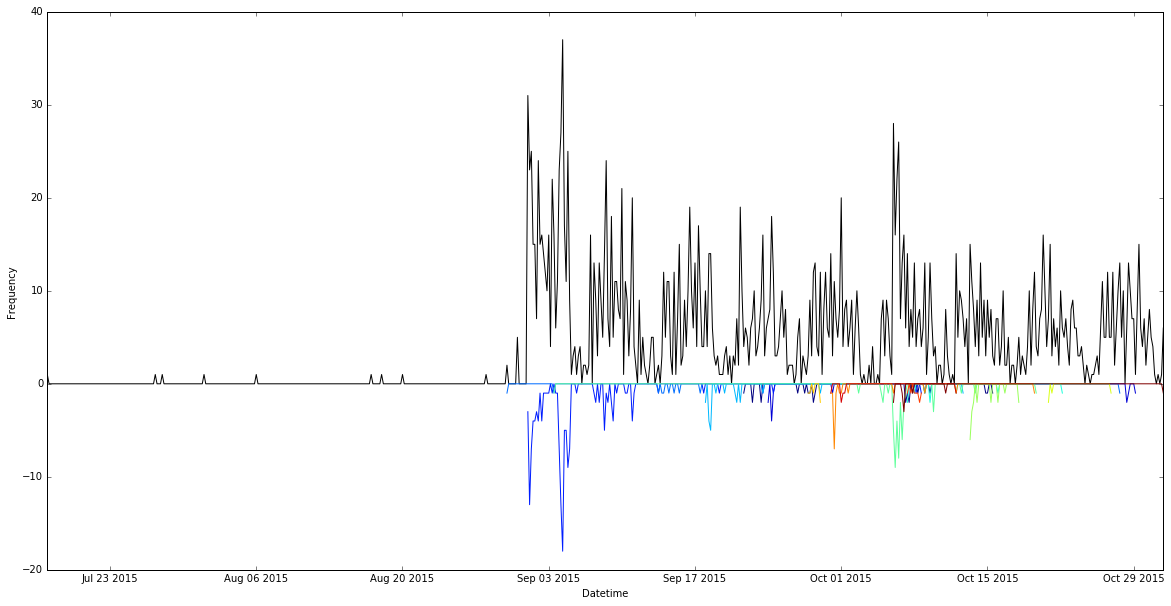

In [122]:
data_preprocess_published = data_preprocess
data_preprocess_published['first-published_dt'] = data_preprocess_published['first-published'].apply(pd.to_datetime)
data_preprocess_published.index = data_preprocess_published['first-published_dt']
global_data = data_preprocess_published.resample('4h',how={'first-published_dt':'count'})
plt.figure(figsize=(20,10))
plt.plot(global_data, color='k')
plt.xlabel('Datetime')
plt.ylabel('Frequency')

events = data_merge['event'].unique()
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(events)))

for (name, group), color in zip(data_merge.groupby('event'), colors):
    group['first-published_dt'] = group['first-published'].apply(pd.to_datetime)
    group.index = group['first-published_dt']
    event_data = group.resample('4h',how={'first-published_dt':'count'})
    plt.plot(-event_data, color=color)
    
# plt.xticklabels('Day')

In [84]:
data_preprocess['first-published'].resample

array(['2015-07-17T01:00:00.000000000+0100',
       '2015-07-27T11:51:10.000000000+0100',
       '2015-07-28T01:01:00.000000000+0100', ...,
       '2015-10-31T22:57:39.000000000+0000',
       '2015-10-31T23:13:34.000000000+0000',
       '2015-10-31T23:25:37.000000000+0000'], dtype='datetime64[ns]')

In [13]:
f1_clus = [0.684211, 0.218750, 0.666667, 0.412698, 0.700000, 0.750000, 0.800000, 0.933333, 0.950000, 0.823529, 0.666667, 1.000000, 0.641026, 0.947368]

In [15]:
plt.bar(f1_clus)

TypeError: bar() takes at least 2 arguments (1 given)

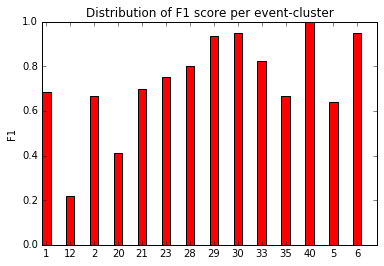

In [16]:
N = len(f1_clus)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

    
p1 = plt.bar(ind, f1_clus, width, color='r')

plt.ylabel('F1')
plt.title('Distribution of F1 score per event-cluster')
plt.xticks(ind + width/2., fn.split(','))
# plt.yticks(np.arange(0, 81, 10))

plt.show()

In [19]:
import scipy as sp
import numpy as np

In [20]:
np.corrcoef(f1_clus, f_len)

array([[ 1.        , -0.25772323],
       [-0.25772323,  1.        ]])

In [21]:
np.corrcoef(f1_clus, e_len)

array([[ 1.        , -0.18185533],
       [-0.18185533,  1.        ]])

ValueError: too many values to unpack